# Linked Structures

## Agenda

1. Motivation
2. Wishlist
3. Mechanisms
4. Linked Data Structures

## 1. Motivation: built-in, array-backed list runtimes

What are the runtime complexities of some common operations for updating an array-backed list?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit

### Index-based update

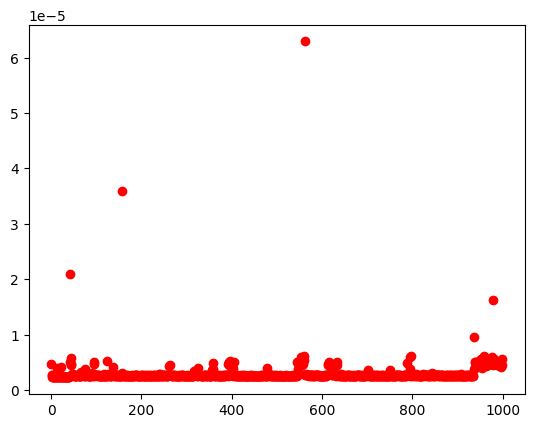

In [4]:
size = 10_000

ts = [timeit('lst[{}] = None'.format(n),
             setup=f'lst = list(range({size}))',
             number=100)
      for n in range(0, size, 10)]

plt.plot(ts, 'ro');

### Appending

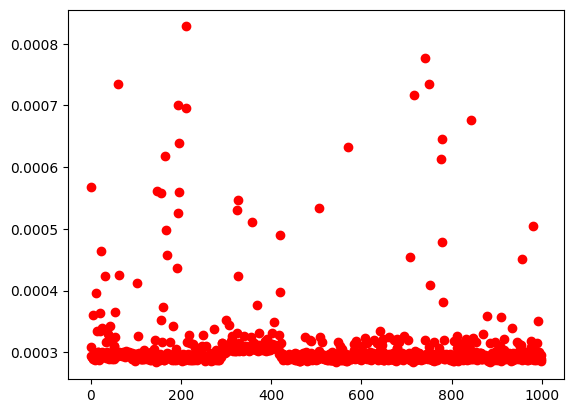

In [9]:
ts = [timeit('lst.append(None)',
             setup=f'lst = list(range({n}))',
             number=10000)
      for n in np.linspace(1000, 100_000, 1000, dtype=int)]

plt.plot(ts, 'ro');

### Insertion & Deletion

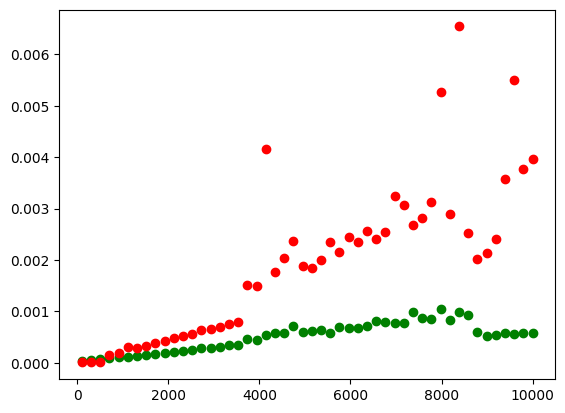

In [12]:
ns = np.linspace(100, 10000, 50, dtype=int)

# timing insertion at front
ins_ts = [timeit('lst.insert(0, None)',
                 setup=f'lst = list(range({n}))',
                 number=100)
          for n in ns]

# timing deletion at front
del_ts = [timeit('del lst[0]',
                 setup=f'lst = list(range({n}))',
                 number=100)
          for n in ns]

plt.plot(ns, ins_ts, 'go')
plt.plot(ns, del_ts, 'ro');

### Concatenation

In [13]:
def concat1(lst1, lst2):
    for x in lst2:
        lst1.append(x)
    return lst1

def concat2(lst1, lst2):
    lst1.extend(lst2)
    return lst1

def concat3(lst1, lst2):
    return lst1 + lst2

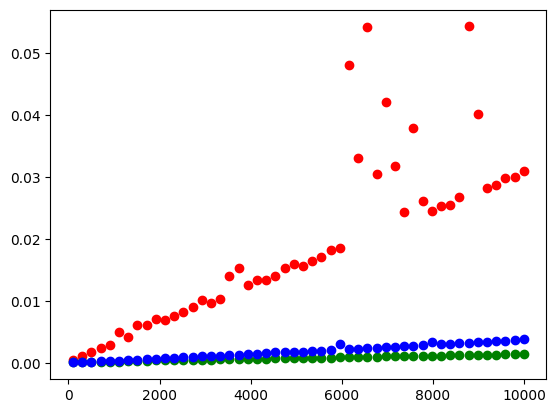

In [14]:
ns = np.linspace(100, 10000, 50, dtype=int)

ts = [[timeit(f'{fn}(lst1, lst2)',
              setup=f'lst1 = list(range({n})); lst2 = list(range({n}))',
              number=100,
              globals=globals())
       for n in ns] 
      for fn in ('concat1', 'concat2', 'concat3')]

plt.plot(ns, ts[0], 'ro')
plt.plot(ns, ts[1], 'go')
plt.plot(ns, ts[2], 'bo');

### Conclusion

While index-based updates and appends are $O(1)$, operations that may require changing the relative positions of elements en masse (e.g., insertion, deletion, concatenation) are $O(N)$. 

This is due to the **monolithic, contiguous memory allocation** of the array used to hold references to elements in the list.

## 2. Wishlist

For applications that frequently perform operations such as insertions & deletions (which are inefficient in an array-backed list) we would like to have an improved storage mechanism that:

- does **not** require monolithic, contiguous memory allocation,
- supports flexible and efficient reorganization of substructures (e.g., for concatenation and relocation),
- and allows us to build other commonly needed operations (e.g., for indexing, iteration, search) on top of it.

## 3. Mechanisms

### 3.1. Two-Element Lists

In [15]:
# data items
i1 = 'lions'
i2 = 'tigers'
i3 = 'bears'
i4 = 'oh, my'

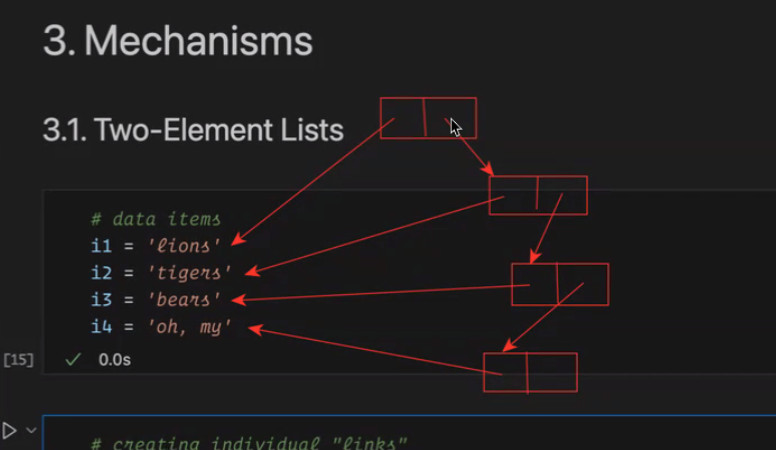

Each arrow refers to the memory address of the following list. We have created several disconnected nodes and connected them with references.

In [30]:
# creating individual "links"
l1 = [i1, None]
l2 = [i2, None]
l3 = [i3, None]
l4 = [i4, None]

In [31]:
# link-ing them together
l1[1] = l2
l2[1] = l3
l3[1] = l4

In [32]:
# data access
head = l1
(
    head[0],
    head[1][0],
    head[1][1][0],
    head[1][1][1][0]
)

('lions', 'tigers', 'bears', 'oh, my')

In [33]:
# iteration
def link_iterator(l):
    while l:
        yield l[0]
        l = l[1]

In [34]:
for x in link_iterator(head):
    print(x)

lions
tigers
bears
oh, my


In [35]:
# prepending
i0 = 'walruses'
l0 = [i0, head]
head = l0

Insertion is really efficient in linked structures since no memory reallocation is needed.

In [36]:
for x in link_iterator(head):
    print(x)

walruses
lions
tigers
bears
oh, my


In [37]:
# insertion
i2_5 = 'elephants'
l2_5 = [i2_5, l3]
l2[1] = l2_5

In [38]:
for x in link_iterator(head):
    print(x)

walruses
lions
tigers
elephants
bears
oh, my


In [39]:
# deletion
head = head[1]
l2[1] = l3

In [41]:
for x in link_iterator(head):
    print(x)

lions
tigers
bears
oh, my


### 3.2. "Node" objects

In [42]:
class Node:
    def __init__(self, val, next=None):
        self.val = val
        self.next = next

In [43]:
# manually constructing a list
n1 = Node(i1)
n2 = Node(i2)
n3 = Node(i3)
n4 = Node(i4)

n1.next = n2
n2.next = n3
n3.next = n4

In [45]:
# data access
head = n1
(
    head.val,
    head.next.val,
    head.next.next.next.val
)

('lions', 'tigers', 'oh, my')

In [46]:
# iteration
def node_iterator(n):
    while n is not None:
        yield n.val
        n = n.next

In [47]:
for x in node_iterator(head):
    print(x)

lions
tigers
bears
oh, my


## 4. Linked Data Structures

### 4.1 Linked List

In [48]:
class LinkedList:
    class Node:
        def __init__(self, val, next=None):
            self.val = val
            self.next = next

    def __init__(self):
            self.head = None # List is empty
        
    def prepend(self, val):
        n = LinkedList.Node(val)
        n.next = self.head
        self.head = n
        
    def __iter__(self):
        n = self.head
        while n is not None:
            yield n.val
            n = n.next
            
    def __repr__(self):
        return '['+', '.join(repr(x) for x in self) + ']'

In [49]:
l = LinkedList()
for x in range(10):
    l.prepend(x)
l

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

Note that nodes in the linked list point to each other, so the Node class is said to be *self-referential*.

### 4.2 Binary Tree

In [50]:
class BinaryNode:
    def __init__(self, val, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right

In [51]:
# an "expression tree" representing the arithmetic expression ((5+3)*(8-4))
t = BinaryNode('*')
t.left = BinaryNode('+')
t.left.left  = BinaryNode('5')
t.left.right = BinaryNode('3')
t.right = BinaryNode('-')
t.right.left  = BinaryNode('8')
t.right.right = BinaryNode('4')

In [52]:
def print_expr_tree(t):
    if t:
        if not t.val.isdigit():
            print('(', end='')
        print_expr_tree(t.left)
        print(t.val, end='')
        print_expr_tree(t.right)
        if not t.val.isdigit():
            print(')', end='')

In [53]:
print_expr_tree(t)

((5+3)*(8-4))

### 4.3 N-ary Tree

In [54]:
class NaryNode:
    def __init__(self, val, n=2):
        self.val = val
        self.children = [None] * n
        
    def __getitem__(self, idx):
        return self.children[idx]
    
    def __setitem__(self, idx, val):
        self.children[idx] = val
        
    def __iter__(self):
        for c in self.children:
            yield c

In [55]:
root = NaryNode('Kingdoms', n=5)

root[0] = NaryNode('Animalia', n=35)
root[1] = NaryNode('Plantae', n=12)
root[2] = NaryNode('Fungi', n=7)
root[3] = NaryNode('Protista', n=5)
root[4] = NaryNode('Monera', n=5)

root[2][0] = NaryNode('Chytridiomycota')
root[2][1] = NaryNode('Blastocladiomycota')
root[2][2] = NaryNode('Glomeromycota')
root[2][3] = NaryNode('Ascomycota')
root[2][4] = NaryNode('Basidiomycota')
root[2][5] = NaryNode('Microsporidia')
root[2][6] = NaryNode('Neocallimastigomycota')

def tree_iter(root):
    if root:
        yield root.val
        for c in root:
            yield from tree_iter(c)

In [56]:
for x in tree_iter(root):
    print(x)

Kingdoms
Animalia
Plantae
Fungi
Chytridiomycota
Blastocladiomycota
Glomeromycota
Ascomycota
Basidiomycota
Microsporidia
Neocallimastigomycota
Protista
Monera


The node data structure is the basis for more flexible and complex data structures.